<a href="https://colab.research.google.com/github/Tien84/BitcoinPrediction/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Flatten, TimeDistributed, ConvLSTM2D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [ ]:
hist = pd.read_csv('/content/driver/My Drive/DataSet/DataBitcoin.csv')
hist = hist.set_index('Date')
hist.index = pd.to_datetime(hist.index)
target_col = 'Adj Close'

In [ ]:
hist.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-11-03,361.872986,417.899994,357.647003,403.416992,403.416992,206162000
2015-11-04,403.664001,495.562012,380.548004,411.562988,411.562988,263900000
2015-11-05,408.076996,447.561005,374.580994,386.354004,386.354004,151824992
2015-11-06,388.046997,395.835999,354.024994,374.470001,374.470001,122687000
2015-11-07,374.269012,390.585999,372.433014,386.481995,386.481995,56625100


In [ ]:
hist.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-30,20817.982422,20917.005859,20547.462891,20635.603516,20635.603516,31486345556
2022-10-31,20633.695313,20795.320313,20287.458984,20495.773438,20495.773438,45668466815
2022-11-01,20494.898438,20647.289063,20359.845703,20485.273438,20485.273438,39819303159
2022-11-02,20482.958984,20742.810547,20087.134766,20159.503906,20159.503906,55552169483
2022-11-03,20158.783203,20335.416016,20148.492188,20335.416016,20335.416016,56120430592


In [ ]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [ ]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [ ]:
train, test = train_test_split(hist, test_size=0.2)

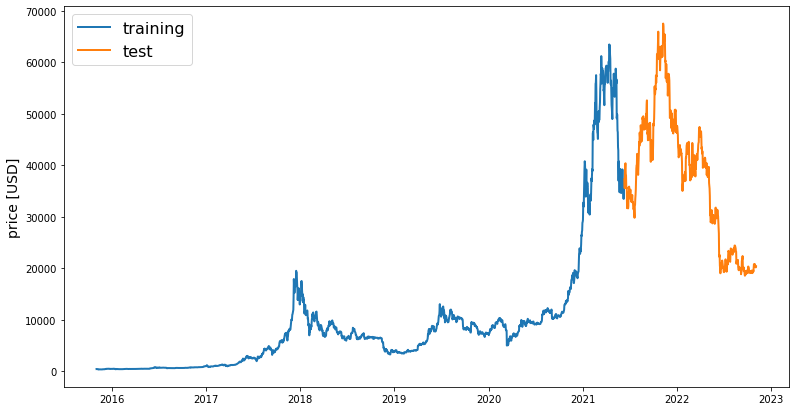

In [ ]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [ ]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

In [ ]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 50
batch_size = 30
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
69/69 [==============================] - 4s 8ms/step - loss: 0.0038
Epoch 2/50
69/69 [==============================] - 1s 8ms/step - loss: 0.0026
Epoch 3/50
69/69 [==============================] - 1s 11ms/step - loss: 0.0021
Epoch 4/50
69/69 [==============================] - 1s 15ms/step - loss: 0.0020
Epoch 5/50
69/69 [==============================] - 1s 17ms/step - loss: 0.0020
Epoch 6/50
69/69 [==============================] - 1s 17ms/step - loss: 0.0019
Epoch 7/50
69/69 [==============================] - 1s 17ms/step - loss: 0.0018
Epoch 8/50
69/69 [==============================] - 1s 13ms/step - loss: 0.0017
Epoch 9/50
69/69 [==============================] - 1s 7ms/step - loss: 0.0018
Epoch 10/50
69/69 [==============================] - 1s 8ms/step - loss: 0.0017
Epoch 11/50
69/69 [==============================] - 1s 8ms/step - loss: 0.0017
Epoch 12/50
69/69 [==============================] - 1s 8ms/step - loss: 0.0017
Epoch 13/50
69/69 [========================

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               42800     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 42,901
Trainable params: 42,901
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

16/16 [==============================] - 1s 3ms/step


0.024985270341687935

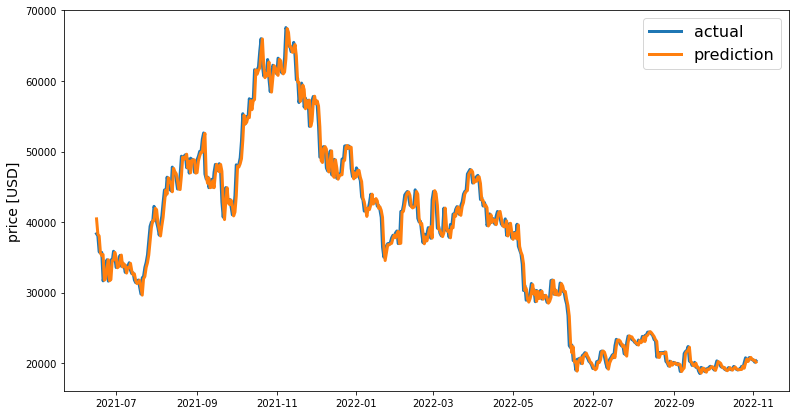

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
predictions= model.predict(X_test) 
mse = mean_squared_error(y_test, predictions)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

16/16 [==============================] - 0s 3ms/step
RMSE: 0.034216


In [ ]:
mape = np.mean(np.abs(np.array(preds) - np.array(test))/np.abs(test))
print('MAPE: ' + str(mape))

ValueError: ignored